# Introduction

Blah blah

# Loading Libraries

In [1]:
# linear algebra
import numpy as np

# data processing
import pandas as pd
import re

# fancy tables
import qgrid
from termcolor import colored

# data visualization
import seaborn as sns

# suppressing pesky warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import model_selection

import optuna
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection

In [2]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# Exploratory Data Analysis

## Loading Data

We will be first loading the data from Kaggle competiton website. 

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

In [4]:
train = int(round(len(train_df) / (len(train_df) + len(test_df)), 2) * 100)
test = int(round(len(test_df) / (len(train_df) + len(test_df)), 2) * 100)
print (colored(("The train to test ratio is {0}:{1}".format(train, test)), 'red', attrs=['bold']))

The train to test ratio is 68:32


## Check Missing Data

### Train Data

In [5]:
# Quick check to see data columns
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum() / train_df.isnull().count() * 100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_train = pd.concat([total, percent_2], axis=1, keys=["Total", "%"])
missing_data_train

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
SibSp,0,0.0
Parch,0,0.0


In [6]:
qgrid_widget = qgrid.show_grid(missing_data_train, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Test Data

In [7]:
# Quick check to see data columns
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum() / test_df.isnull().count() * 100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent_2], axis=1, keys=["Total", "%"])
missing_data_test

,Total,%
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0


## Data Elements

### Age and Sex

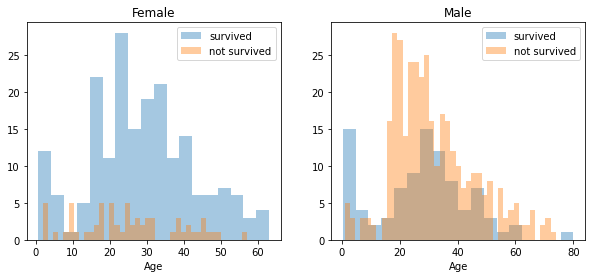

In [8]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

### Embarked, Pclass and Sex

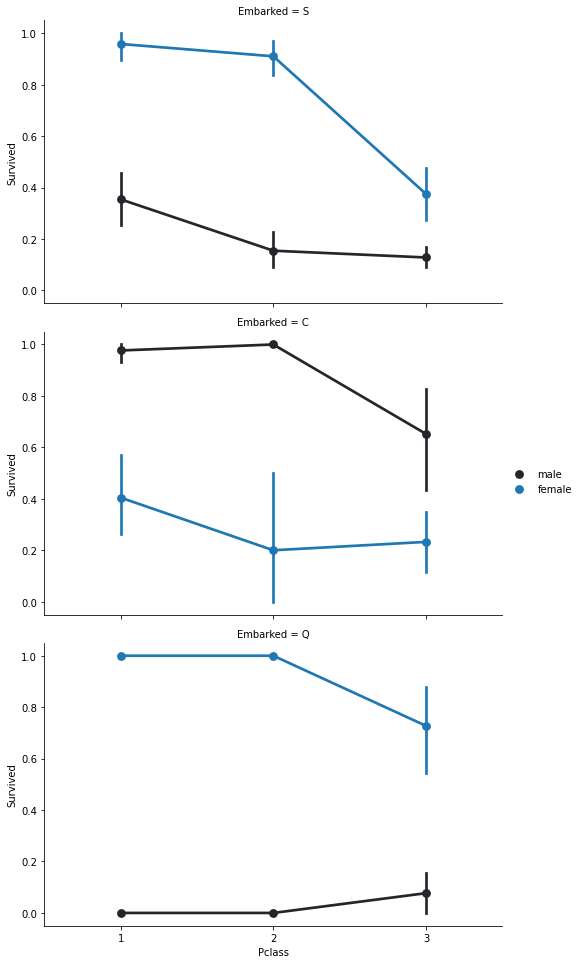

In [9]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

### Pclass

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

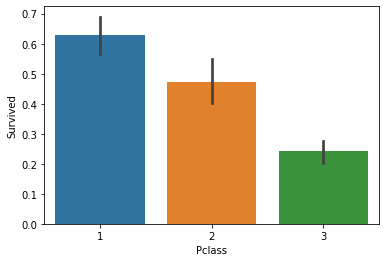

In [10]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

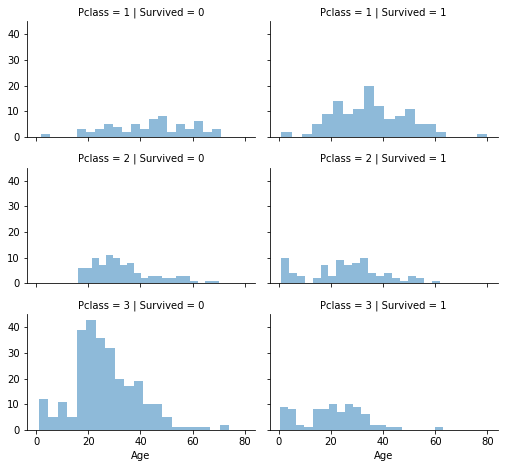

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### SibSp and Parch

In [12]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

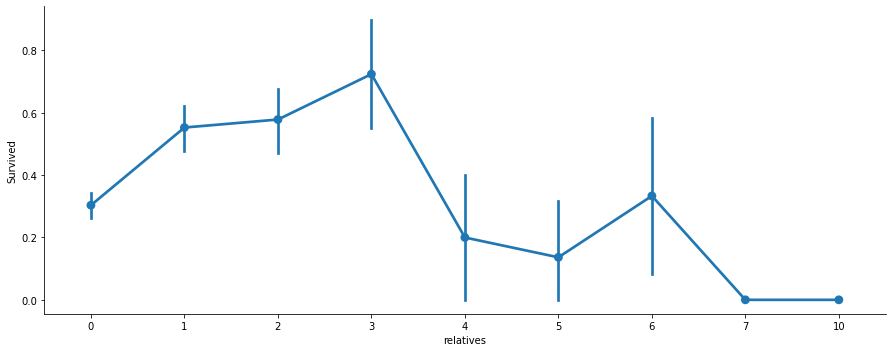

In [13]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

## Data Preprocessing

### Dropping Columns

In [14]:
train_df = train_df.drop(['PassengerId'], axis=1)

### Missing Data

#### Cabin

In [15]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Age

In [16]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

#### Embarked

In [17]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [18]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [19]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

### Converting Feature

#### Fare

In [20]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Name

In [21]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### Sex

In [22]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Ticket

In [23]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

### Creating Categories

#### Age

In [24]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

#### Fare

In [25]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

### Creating New Categories

#### Age time Class

In [26]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per person

In [27]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

# Model

In [28]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

## Stochastic Gradient Descent (SGD)

In [29]:
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

## Random Forest

In [30]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

## Logistic Regression

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

## K Nearest Neighbor:

In [32]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

## Gaussian Naive Bayes:

In [33]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

## Perceptron:

In [34]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

## Linear Support Vector Machine:

In [35]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

## Decision Tree

In [36]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train) 
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## Best Model

In [37]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
92.82,Random Forest
92.82,Decision Tree
85.97,KNN
81.59,Logistic Regression
81.26,Support Vector Machines
77.67,Naive Bayes
77.10,Perceptron
73.96,Stochastic Gradient Decent


## K-Fold Cross Validation:

In [38]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76666667 0.83146067 0.74157303 0.83146067 0.84269663 0.85393258
 0.85393258 0.7752809  0.85393258 0.83146067]
Mean: 0.8182397003745319
Standard Deviation: 0.03915033065447534


### Feature Importance

In [39]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.193
Sex,0.175
Age_Class,0.098
Deck,0.083
Age,0.081
Pclass,0.076
Fare,0.067
relatives,0.059
Embarked,0.053


<AxesSubplot:xlabel='feature'>

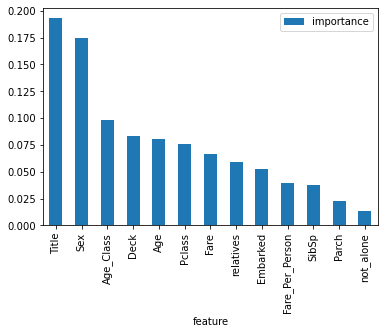

In [40]:
importances.plot.bar()

In [41]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

### Retraining model

In [42]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100,  oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.82 %


## Hyperparameter Tuning

In [43]:
#Step 1. Define an objective function to be maximized.
def objective(trial):

    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        classifier_obj = linear_model.LogisticRegression(C=logreg_c)
    else:
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = ensemble.RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_n_estimators
        )

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, Y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2021-12-20 16:41:23,798] A new study created in memory with name: no-name-6b34dc52-dbfb-4333-a65c-4bdaf35ab8b2
[I 2021-12-20 16:41:28,154] Trial 0 finished with value: 0.829405162738496 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 746, 'rf_max_depth': 4}. Best is trial 0 with value: 0.829405162738496.
[I 2021-12-20 16:41:30,755] Trial 1 finished with value: 0.8148148148148149 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 693, 'rf_max_depth': 9}. Best is trial 0 with value: 0.829405162738496.
[I 2021-12-20 16:41:32,068] Trial 2 finished with value: 0.7957351290684623 and parameters: {'classifier': 'LogReg', 'logreg_c': 9822.277336775514}. Best is trial 0 with value: 0.829405162738496.
[I 2021-12-20 16:41:34,406] Trial 3 finished with value: 0.8215488215488215 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 504, 'rf_max_depth': 7}. Best is trial 0 with value: 0.829405162738496.
[I 2021-12-20 16:41:36,099] Trial 4 finished with

[I 2021-12-20 16:42:11,084] Trial 36 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 941, 'rf_max_depth': 4}. Best is trial 13 with value: 0.8294051627384961.
[I 2021-12-20 16:42:11,139] Trial 37 finished with value: 0.7957351290684623 and parameters: {'classifier': 'LogReg', 'logreg_c': 1525493610.0546749}. Best is trial 13 with value: 0.8294051627384961.
[I 2021-12-20 16:42:12,813] Trial 38 finished with value: 0.8114478114478114 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 695, 'rf_max_depth': 11}. Best is trial 13 with value: 0.8294051627384961.
[I 2021-12-20 16:42:14,653] Trial 39 finished with value: 0.8148148148148149 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 814, 'rf_max_depth': 8}. Best is trial 13 with value: 0.8294051627384961.
[I 2021-12-20 16:42:14,675] Trial 40 finished with value: 0.6161616161616161 and parameters: {'classifier': 'LogReg', 'logreg_c': 2.529729167880695e

[I 2021-12-20 16:43:02,483] Trial 72 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 902, 'rf_max_depth': 5}. Best is trial 68 with value: 0.8305274971941637.
[I 2021-12-20 16:43:03,965] Trial 73 finished with value: 0.829405162738496 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 741, 'rf_max_depth': 4}. Best is trial 68 with value: 0.8305274971941637.
[I 2021-12-20 16:43:05,428] Trial 74 finished with value: 0.8282828282828282 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 728, 'rf_max_depth': 4}. Best is trial 68 with value: 0.8305274971941637.
[I 2021-12-20 16:43:06,612] Trial 75 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 559, 'rf_max_depth': 4}. Best is trial 68 with value: 0.8305274971941637.
[I 2021-12-20 16:43:07,384] Trial 76 finished with value: 0.8237934904601572 and parameters: {'classifier': 'RandomForest', 'rf_n_est

[I 2021-12-20 16:43:59,311] Trial 108 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 723, 'rf_max_depth': 7}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:01,336] Trial 109 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 886, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:03,115] Trial 110 finished with value: 0.8249158249158248 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 846, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:05,223] Trial 111 finished with value: 0.8204264870931537 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 914, 'rf_max_depth': 8}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:06,952] Trial 112 finished with value: 0.8260381593714926 and parameters: {'classifier': 'RandomForest', 'rf

[I 2021-12-20 16:44:55,530] Trial 144 finished with value: 0.829405162738496 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 890, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:57,165] Trial 145 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 783, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:44:58,810] Trial 146 finished with value: 0.830527497194164 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 836, 'rf_max_depth': 4}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:45:00,799] Trial 147 finished with value: 0.8260381593714926 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 836, 'rf_max_depth': 5}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:45:02,630] Trial 148 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n

[I 2021-12-20 16:45:55,299] Trial 180 finished with value: 0.8148148148148149 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 985, 'rf_max_depth': 10}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:45:57,030] Trial 181 finished with value: 0.830527497194164 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 857, 'rf_max_depth': 4}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:45:58,882] Trial 182 finished with value: 0.8294051627384961 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 870, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:00,731] Trial 183 finished with value: 0.8305274971941637 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 861, 'rf_max_depth': 4}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:02,344] Trial 184 finished with value: 0.8148148148148149 and parameters: {'classifier': 'RandomForest', 'rf

[I 2021-12-20 16:46:30,670] Trial 216 finished with value: 0.8181818181818182 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 10, 'rf_max_depth': 6}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:30,796] Trial 217 finished with value: 0.8226711560044894 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 44, 'rf_max_depth': 7}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:31,247] Trial 218 finished with value: 0.8305274971941637 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 200, 'rf_max_depth': 7}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:31,595] Trial 219 finished with value: 0.8204264870931537 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 147, 'rf_max_depth': 8}. Best is trial 97 with value: 0.8327721661054994.
[I 2021-12-20 16:46:32,147] Trial 220 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n

[I 2021-12-20 16:46:46,415] Trial 252 finished with value: 0.8226711560044894 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 838, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:46:46,732] Trial 253 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 138, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:46:46,969] Trial 254 finished with value: 0.8260381593714928 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 98, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:46:47,273] Trial 255 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 109, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:46:48,537] Trial 256 finished with value: 0.8237934904601572 and parameters: {'classifier': 'RandomForest', 

[I 2021-12-20 16:47:11,901] Trial 288 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 210, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:12,325] Trial 289 finished with value: 0.8305274971941637 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 185, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:13,431] Trial 290 finished with value: 0.8294051627384961 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 552, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:15,057] Trial 291 finished with value: 0.8305274971941637 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 772, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:15,163] Trial 292 finished with value: 0.8237934904601572 and parameters: {'classifier': 'RandomForest',

[I 2021-12-20 16:47:38,491] Trial 324 finished with value: 0.8260381593714926 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 242, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:38,794] Trial 325 finished with value: 0.8237934904601572 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 143, 'rf_max_depth': 3}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:40,726] Trial 326 finished with value: 0.8260381593714926 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 911, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:40,863] Trial 327 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 51, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:47:41,138] Trial 328 finished with value: 0.8294051627384961 and parameters: {'classifier': 'RandomForest', 

[I 2021-12-20 16:48:06,117] Trial 360 finished with value: 0.8215488215488215 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 850, 'rf_max_depth': 8}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:07,019] Trial 361 finished with value: 0.8148148148148149 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 428, 'rf_max_depth': 23}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:08,110] Trial 362 finished with value: 0.8271604938271605 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 588, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:09,581] Trial 363 finished with value: 0.8226711560044894 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 804, 'rf_max_depth': 8}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:09,865] Trial 364 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest'

[I 2021-12-20 16:48:35,959] Trial 396 finished with value: 0.7059483726150392 and parameters: {'classifier': 'LogReg', 'logreg_c': 0.0008095253054812608}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:37,165] Trial 397 finished with value: 0.8294051627384961 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 551, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:39,312] Trial 398 finished with value: 0.8114478114478114 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 905, 'rf_max_depth': 17}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:39,598] Trial 399 finished with value: 0.8316498316498316 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 123, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:48:39,855] Trial 400 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estima

[I 2021-12-20 16:49:12,726] Trial 432 finished with value: 0.8282828282828283 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 984, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:14,708] Trial 433 finished with value: 0.830527497194164 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 988, 'rf_max_depth': 4}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:14,929] Trial 434 finished with value: 0.8181818181818182 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 84, 'rf_max_depth': 7}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:15,362] Trial 435 finished with value: 0.8327721661054994 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 196, 'rf_max_depth': 5}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:15,416] Trial 436 finished with value: 0.7968574635241302 and parameters: {'classifier': 'LogReg', 'logreg

[I 2021-12-20 16:49:40,682] Trial 468 finished with value: 0.8204264870931537 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 91, 'rf_max_depth': 5}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:41,104] Trial 469 finished with value: 0.8294051627384961 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 153, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:41,509] Trial 470 finished with value: 0.8237934904601572 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 134, 'rf_max_depth': 6}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:41,876] Trial 471 finished with value: 0.8114478114478114 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 108, 'rf_max_depth': 31}. Best is trial 237 with value: 0.8338945005611672.
[I 2021-12-20 16:49:42,412] Trial 472 finished with value: 0.8260381593714926 and parameters: {'classifier': 'RandomForest',

In [44]:
# Getting the best trial:
print(f"The best trial is : \n{study.best_trial}")

# Getting the best score:
print(f"The best value is : \n{study.best_value}")

# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")


The best trial is : 
FrozenTrial(number=237, values=[0.8338945005611672], datetime_start=datetime.datetime(2021, 12, 20, 16, 46, 38, 648310), datetime_complete=datetime.datetime(2021, 12, 20, 16, 46, 38, 968015), params={'classifier': 'RandomForest', 'rf_n_estimators': 146, 'rf_max_depth': 6}, distributions={'classifier': CategoricalDistribution(choices=('LogReg', 'RandomForest')), 'rf_n_estimators': IntUniformDistribution(high=1000, low=10, step=1), 'rf_max_depth': IntLogUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=237, state=TrialState.COMPLETE, value=None)
The best value is : 
0.8338945005611672
The best parameters are : 
{'classifier': 'RandomForest', 'rf_n_estimators': 146, 'rf_max_depth': 6}


In [45]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=645, max_depth=4, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

83.84 %
